# A. ClaMP 데이터셋을 활용한, PE 파일의 header 및 일부 정적 정보를 이용한 악성 코드 탐지 모델 작성

이 노트북에서는 scikit-learn 모듈을 사용합니다.

In [21]:
import os, sys
import urllib.request
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras as keras
from keras.utils import plot_model
import sklearn as sklearn

# 1. 학습자료 확보

이 노트북에서 사용하는 예제는 아래 링크에서 공개된 자료입니다.

아래 링크는 PE 헤더를 이용한 malware 탐지를 위해 필요한 PE 헤더의 분석 자료를 csv 형태로 제공합니다.

A Malware classifier dataset built with header fields’ values of Portable Executable files : https://github.com/urwithajit9/ClaMP

자세한 내용은 위 링크를 클릭하여 살펴보시기 바랍니다.

## 1-1. malware 분류 자료 다운받기

위 github에서 제공하는 여러 자료 중에서 세 가지 자료를 내려받습니다.

1. ClaMP_Integrated-5184.csv
    - ClaMP 메인 데이터셋
    - PE header에서 추출한 정보 및 PE 파일을 가공한 정보 등 악성 코드 여부 판별을 위한 정보 68종
    - 악성 코드 여부(class) 정보 1종(0 또는 1)
2. Malware_VT_report_without_Zipped_3817.csv
    - ClaMP 추가 데이터셋
    - Virus Total에서 크롤링한 정보가 담겨 있음
        - 의심스러운 파일의 MD5 hash
        - 그 파일을 악성 코드로 진단한 백신 등의 개수
        - 각 백신 회사의 진단명
3. Malware-2722_hash_size_entropy.csv
    - ClaMP 추가 데이터셋
        - 의심스러운 파일의 MD5 hash
        - 그 파일의 파일 크기
        - 그 파일의 entropy

In [2]:
ClaMP_dataset_filename = 'ClaMP_Integrated-5184.csv'
ClaMP_malware_class_filename = 'Malware_VT_report_without_Zipped_3817.csv'
ClaMP_malware_md5_filename = 'Malware-2722_hash_size_entropy.csv'

#아래 URL에서 필요한 CSV 파일을 다운로드합니다.
if not os.path.exists(ClaMP_dataset_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/dataset/ClaMP_Integrated-5184.csv",
                               ClaMP_dataset_filename)
if not os.path.exists(ClaMP_malware_md5_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/raw-samples-metadata/Malware-2722_hash_size_entropy.csv",
                               ClaMP_malware_md5_filename)
if not os.path.exists(ClaMP_malware_class_filename):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/urwithajit9/ClaMP/master/raw-samples-metadata/Malware_VT_report_without_Zipped_3817.csv",
                               ClaMP_malware_class_filename)

In [15]:
original_data = pd.read_csv(ClaMP_dataset_filename)
original_data.info()
print(original_data[:5])

original_data = original_data.drop('packer_type', axis = 1)
print("# of samples  : %d" % (original_data.shape[0]))
print("# of malwares : %d" % (len(original_data[original_data['class'] == 1])))
print("# of benigns  : %d" % (len(original_data[original_data['class'] == 0])))
#마지막 컬럼은 악성코드 여부를 나타내는 결과이므로 feature가 아님!
print("# of features : %d" % (original_data.shape[1] - 1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 70 columns):
e_cblp                         5210 non-null int64
e_cp                           5210 non-null int64
e_cparhdr                      5210 non-null int64
e_maxalloc                     5210 non-null int64
e_sp                           5210 non-null int64
e_lfanew                       5210 non-null int64
NumberOfSections               5210 non-null int64
CreationYear                   5210 non-null int64
FH_char0                       5210 non-null int64
FH_char1                       5210 non-null int64
FH_char2                       5210 non-null int64
FH_char3                       5210 non-null int64
FH_char4                       5210 non-null int64
FH_char5                       5210 non-null int64
FH_char6                       5210 non-null int64
FH_char7                       5210 non-null int64
FH_char8                       5210 non-null int64
FH_char9                  

## 1-2. 자료 가공하기

얻어낸 자료를 학습용 데이터로 바꾸는 함수를 만듭니다. 내부에 뒤섞고, 정규화를 하고, 범주형(categorical) 자료는 one-hot vector로 바꾸는 부분이 들어가는 등 많은 처리를 하느라 함수가 좀 깁니다.

In [17]:
def generate_training_and_test_data(original_data,
                                    idx_features,
                                    idx_class,
                                    cv_ratio = 0.8,
                                    normalize = True,
                                    convert_categorical_to_ohv = True):
    x_data = np.array(original_data[:, idx_features], dtype = np.float32)
    y_data = np.array(original_data[:, idx_class], dtype = np.int32)

    num_features = len(idx_features)
    num_classes  = np.max(y_data) + 1

    rand_idx = np.arange(0, len(x_data))
    np.random.shuffle(rand_idx)

    len_train = int(len(rand_idx) * cv_ratio)
    len_test = len(rand_idx) - len_train

    x_train = x_data[rand_idx[:len_train]]
    y_train = y_data[rand_idx[:len_train]]
    if convert_categorical_to_ohv:
        y_train = keras.utils.to_categorical(y_train, num_classes)

    x_test = x_data[rand_idx[len_train:]]
    y_test = y_data[rand_idx[len_train:]]
    if convert_categorical_to_ohv:
        y_test = keras.utils.to_categorical(y_test, num_classes)

    #이제 정규화를 좀 합시다.
    if normalize:
        x_max = np.max(x_data, axis = 0)
        x_min = np.min(x_data, axis = 0)
        x_train = (x_train - x_min) / (x_max - x_min + 1e-7)
        x_test  = (x_test  - x_min) / (x_max - x_min + 1e-7)

    print("shape of x_train and y_train : ", x_train.shape, y_train.shape)
    print("shape of x_test  and y_test  : ", x_test.shape, y_test.shape)
    
    return x_train, y_train, x_test, y_test, num_features, num_classes

# 2. 보조함수 작성

scikit-learn은 기계학습 모델 평가를 위한 다양한 함수를 제공합니다. 이 함수들을 이용해서, 학습 결과를 시각화하는 보조함수들을 만듭니다.

In [5]:
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def do_confusion(test, pred):
    cnf_matrix = confusion_matrix(test, pred)
    plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'])
    
    return accuracy_score(test, pred)

def do_f1(test, pred):
    return f1_score(test, pred)

# 3. 기계학습 / 신경망 모델을 이용한 악성 코드 판정 모델

이제 악성 코드 판정을 위한 모델을 만들 차례입니다. 우선 decision tree와 random forest를 사용해 봅시다.

In [47]:
# decision tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

def do_decision(x, y, test):
    clf = tree.DecisionTreeClassifier()
    clf.fit(x, y)
    y_pred = clf.predict(test)
    
    return y_pred


def do_randomforest(x, y, test, returnModel = False):
    clf = RandomForestClassifier(n_estimators=1000, max_depth=200,random_state=0)
    clf.fit(x, y)  
    print(clf.feature_importances_)
    y_pred = clf.predict(test)
    
    if returnModel:
        return y_pred, clf
    else:
        return y_pred

## 3-1. Decision Tree를 이용한 모델

shape of x_train and y_train :  (4168, 68) (4168,)
shape of x_test  and y_test  :  (1042, 68) (1042,)
Confusion matrix, without normalization
[[463  12]
 [ 10 557]]
DT accuracy:  0.9788867562380038
f1 score:  0.9806338028169014


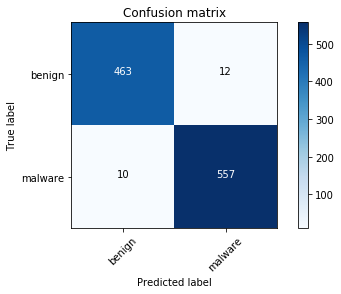

In [19]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(original_data.values,
                                                                                              np.arange(0, 68), 68,
                                                                                              convert_categorical_to_ohv=False)

y_pred = do_decision(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 3-2. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

중간 결과로 출력되는 68개 항목을 가진 벡터(행렬)은, 68개의 feature가 결과에 얼마나 영향을 끼치는지를 계산한 값입니다. 이 값이 클 수록 결과에 미치는 영향이 큽니다. 즉, 더 **중요한** feature입니다. 이것에 대한 분석은 나중에...

[2.66379518e-03 2.31205957e-03 1.91718112e-04 2.11672240e-04
 6.62870893e-04 2.41826649e-02 1.50301788e-02 4.54306565e-04
 5.09252272e-02 0.00000000e+00 5.29309574e-03 5.77203180e-03
 5.44964939e-06 1.73578123e-03 1.13453580e-03 9.16440584e-05
 1.09169312e-03 1.32102690e-03 1.22719475e-03 0.00000000e+00
 1.60347462e-01 0.00000000e+00 1.10516654e-03 1.90374201e-02
 7.73891018e-03 1.67941152e-02 1.33821280e-02 4.10137469e-03
 3.51521569e-02 4.20822374e-03 1.46322593e-02 5.90564518e-03
 0.00000000e+00 0.00000000e+00 1.66275014e-02 9.98261056e-03
 2.35278636e-02 7.79029991e-03 2.04321352e-02 1.08260540e-02
 3.64703662e-04 4.00803675e-04 8.15152010e-02 3.27228448e-02
 3.79864115e-02 4.14865883e-05 5.31584327e-02 0.00000000e+00
 4.65107538e-03 0.00000000e+00 0.00000000e+00 7.58494642e-03
 1.33950971e-04 2.65367740e-06 0.00000000e+00 2.87710867e-02
 6.63005870e-03 4.59357804e-03 1.98702741e-03 3.00781978e-07
 2.60401513e-02 9.63857064e-03 3.38452926e-03 2.17620363e-02
 3.17429651e-02 4.237878

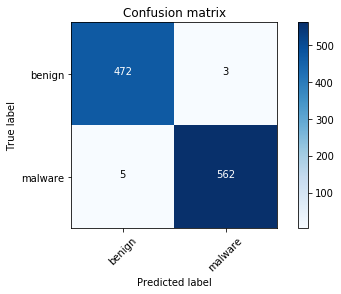

In [20]:
y_pred = do_randomforest(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

보다시피, 간단한 문제에서는 신경망까지 안 가고 잘 정의된 기계학습 모델을 사용하는 것으로 충분합니다.

## 3-3. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 68)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      1380        
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
________________________________________________________________________________
activation_7 (Activation)           (None, 1)                       0           
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________

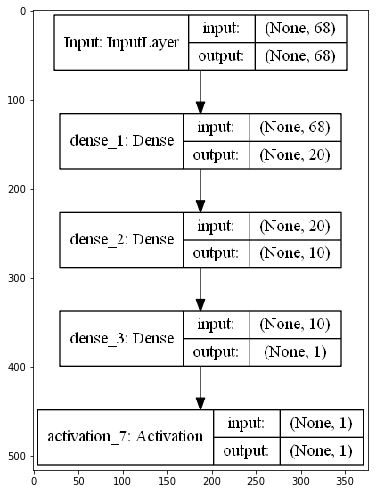

In [96]:
#간단한 모델
num_features = 68
num_classes = 1

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(num_classes, name = 'dense_3')(dense2)
out = keras.layers.Activation('tanh')(dense3)

first_model = keras.Model(inp, out, name = 'first_dnn')
first_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
first_model.summary(80)
plot_model(first_model, to_file='first_dnn.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('first_dnn.png'))

In [42]:
first_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 100)

Train on 4168 samples, validate on 1042 samples
Epoch 1/100
4168/4168 [==============================] - 1s 198us/step - loss: 0.4440 - acc: 0.8287 - val_loss: 0.2639 - val_acc: 0.8839
Epoch 2/100
4168/4168 [==============================] - 0s 118us/step - loss: 0.2494 - acc: 0.8829 - val_loss: 0.2035 - val_acc: 0.9031
Epoch 3/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.2395 - acc: 0.8846 - val_loss: 0.1885 - val_acc: 0.9050
Epoch 4/100
4168/4168 [==============================] - 0s 118us/step - loss: 0.2085 - acc: 0.8824 - val_loss: 0.1735 - val_acc: 0.8925
Epoch 5/100
4168/4168 [==============================] - 0s 118us/step - loss: 0.2005 - acc: 0.8659 - val_loss: 0.1628 - val_acc: 0.8848
Epoch 6/100
4168/4168 [==============================] - 0s 118us/step - loss: 0.1790 - acc: 0.8632 - val_loss: 0.1536 - val_acc: 0.8839
Epoch 7/100
4168/4168 [==============================] - 0s 118us/step - loss: 0.1683 - acc: 0.8563 - val_loss: 0.1504 - val_acc: 

4168/4168 [==============================] - 0s 117us/step - loss: 0.0653 - acc: 0.5936 - val_loss: 0.1264 - val_acc: 0.5902
Epoch 61/100
4168/4168 [==============================] - 0s 117us/step - loss: 0.0749 - acc: 0.6034 - val_loss: 0.1069 - val_acc: 0.5979
Epoch 62/100
4168/4168 [==============================] - 0s 116us/step - loss: 0.0621 - acc: 0.5921 - val_loss: 0.1044 - val_acc: 0.6065
Epoch 63/100
4168/4168 [==============================] - 0s 117us/step - loss: 0.0590 - acc: 0.5921 - val_loss: 0.1979 - val_acc: 0.5768
Epoch 64/100
4168/4168 [==============================] - 0s 117us/step - loss: 0.0633 - acc: 0.5929 - val_loss: 0.1096 - val_acc: 0.6008
Epoch 65/100
4168/4168 [==============================] - 0s 117us/step - loss: 0.0900 - acc: 0.5917 - val_loss: 0.1913 - val_acc: 0.5883
Epoch 66/100
4168/4168 [==============================] - 0s 116us/step - loss: 0.0874 - acc: 0.5890 - val_loss: 0.0963 - val_acc: 0.6036
Epoch 67/100
4168/4168 [=======================

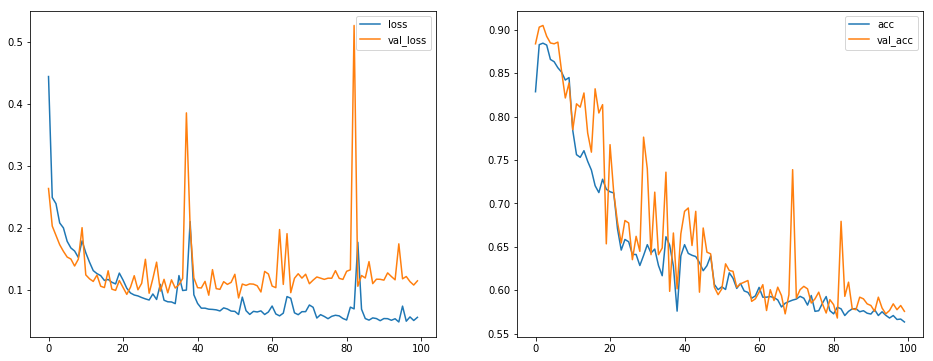

Confusion matrix, without normalization
[[463  12]
 [ 11 556]]
DT accuracy:  0.9779270633397313
f1 score:  0.9797356828193832


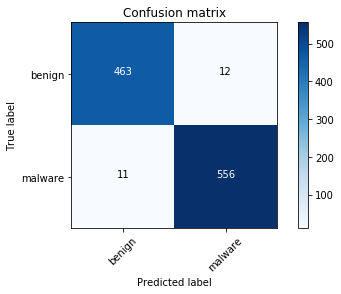

In [43]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(first_model.history.history['loss'])
ax.plot(first_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(first_model.history.history['acc'])
ax.plot(first_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = first_model.predict(x_test) >= 0.5
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

# 결론 : 신경망이 능사는 아닙니다.

# 4. 어떤 feature가 악성 코드 구분에 유용한가?

강의 도중에 나왔던 이야기지만, 자료의 차원(feature의 수)을 줄이면서 모델의 성능을 좋게 하려면

* 서로 상관도가 낮은 feature들을 사용하고,
* 결과와의 상관도가 높은 feature들을 사용하는

것이 유리합니다. 상관도는 pandas.DataFrame의 corr 함수로 계산할 수 있고 seaborn으로는 그걸 그림으로 그려볼 수 있습니다.

## 4-1. 결과와 상관도가 충분히 높은(또는 충분히 낮은) feature를 골라내기

우선 correlation들을 쭉 그려봅시다.

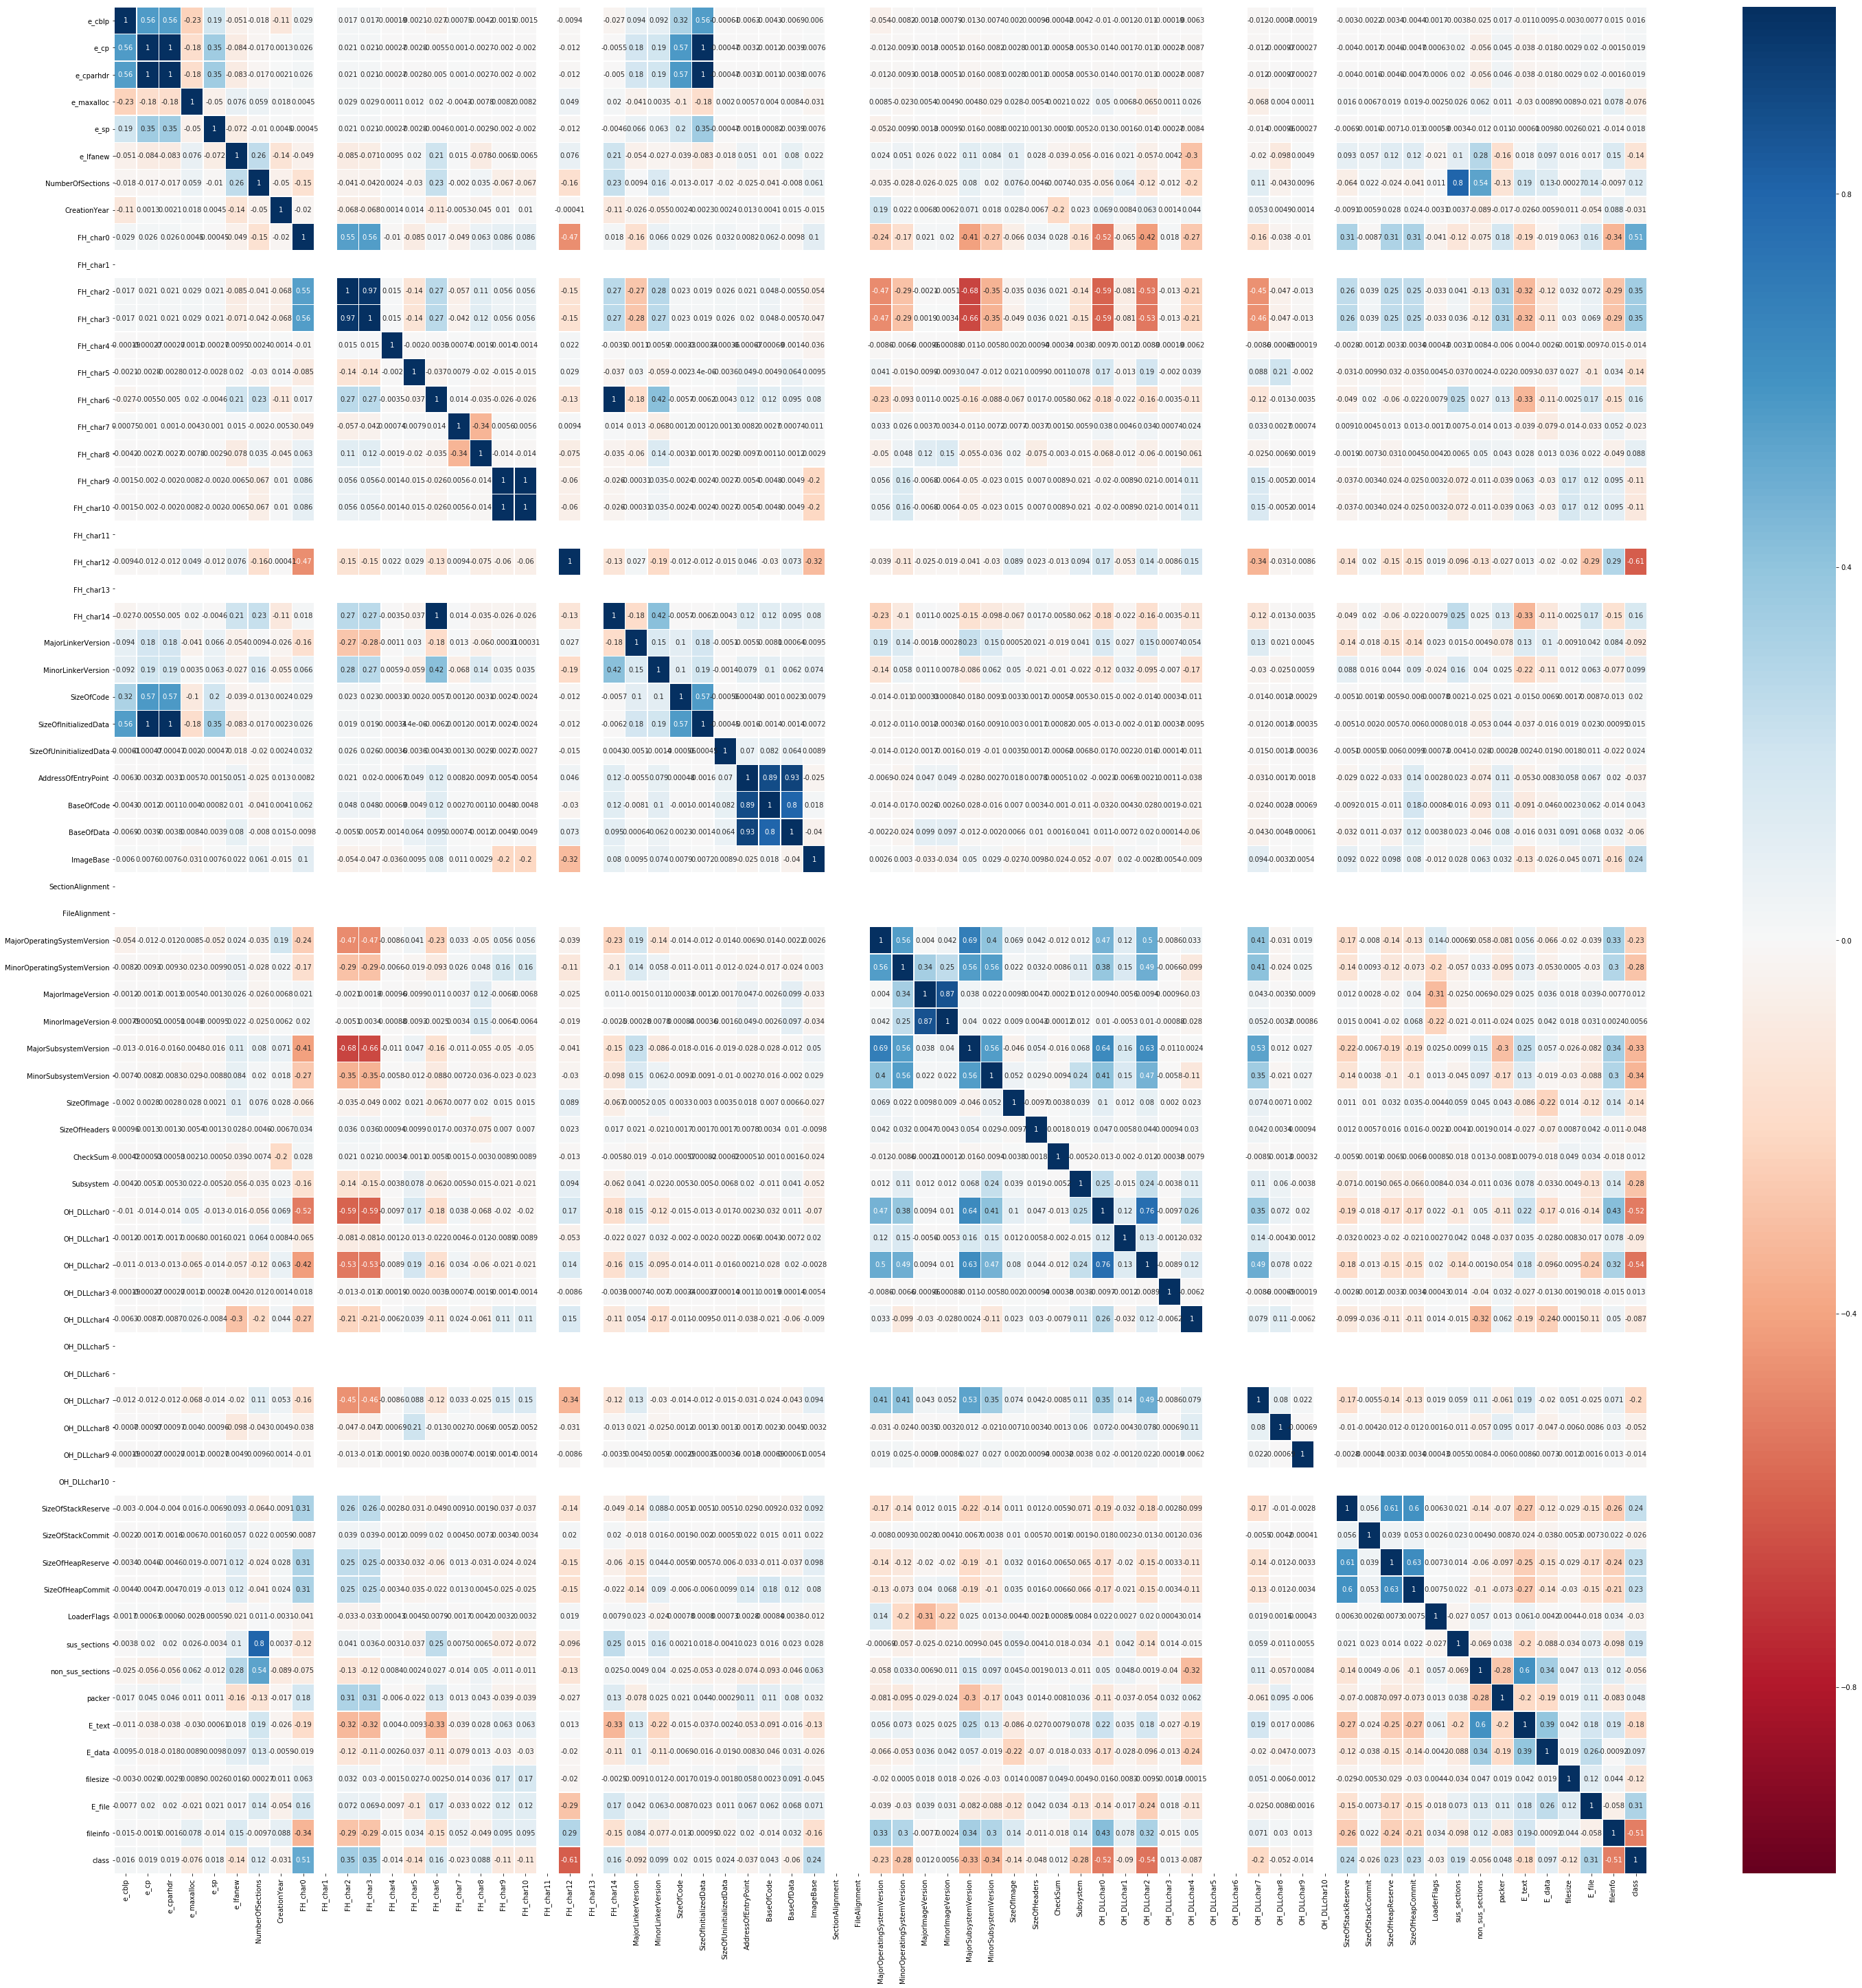

In [53]:
# pip install seaborn  <<- in virtualenv !!
import seaborn as sns

fig, ax = plt.subplots(figsize=(50,50))
corr_matrix = original_data.corr()
sns.heatmap(corr_matrix, annot=True, linewidth=.5, ax=ax, vmin = -1, vmax = 1, cmap = 'RdBu')

In [64]:
corr_matrix

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,LoaderFlags,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class
e_cblp,1.000000,0.563210,0.558907,-0.234032,0.194772,-0.051031,-0.018130,-0.111427,0.029452,NaN,...,0.001722,-0.003797,-0.025019,0.017444,-0.011305,0.009503,-0.002966,0.007731,0.015364,0.015753
e_cp,0.563210,1.000000,0.999986,-0.178953,0.354844,-0.083509,-0.017086,0.001292,0.026059,NaN,...,0.000634,0.019603,-0.056401,0.045410,-0.038192,-0.018221,-0.002872,0.019656,-0.001526,0.018643
e_cparhdr,0.558907,0.999986,1.000000,-0.177449,0.354942,-0.083320,-0.016882,0.002137,0.025959,NaN,...,0.000604,0.019832,-0.056384,0.045535,-0.038451,-0.018374,-0.002859,0.019721,-0.001620,0.018627
e_maxalloc,-0.234032,-0.178953,-0.177449,1.000000,-0.049922,0.075671,0.059057,0.017963,0.004541,NaN,...,-0.002461,0.025970,0.062240,0.010640,-0.029822,0.008901,0.008860,-0.021332,0.078155,-0.075906
e_sp,0.194772,0.354844,0.354942,-0.049922,1.000000,-0.072178,-0.009972,0.004485,-0.000447,NaN,...,0.000593,-0.003436,-0.011854,0.010903,-0.000614,0.009823,-0.002561,0.021028,-0.013608,0.018292
e_lfanew,-0.051031,-0.083509,-0.083320,0.075671,-0.072178,1.000000,0.257631,-0.137053,-0.048792,NaN,...,-0.021157,0.104751,0.283604,-0.160523,0.017977,0.097028,0.016317,0.017121,0.145219,-0.136091
NumberOfSections,-0.018130,-0.017086,-0.016882,0.059057,-0.009972,0.257631,1.000000,-0.050022,-0.150321,NaN,...,0.010687,0.803670,0.538595,-0.133367,0.190598,0.129754,-0.000271,0.136798,-0.009717,0.123998
CreationYear,-0.111427,0.001292,0.002137,0.017963,0.004485,-0.137053,-0.050022,1.000000,-0.019908,NaN,...,-0.003051,0.003688,-0.089085,-0.017226,-0.026379,-0.005855,0.010641,-0.054181,0.087784,-0.031048
FH_char0,0.029452,0.026059,0.025959,0.004541,-0.000447,-0.048792,-0.150321,-0.019908,1.000000,NaN,...,-0.041078,-0.124889,-0.075185,0.177313,-0.186898,-0.018667,0.062911,0.164359,-0.337801,0.511948
FH_char1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


우리가 원하는 결과(**class**)와 상관도의 절대값이 0.1보다 큰 항목들만을 추려내 봅시다.

In [131]:
important_correlations = pd.concat([corr_matrix[corr_matrix['class'] < -0.1], corr_matrix[corr_matrix['class'] > 0.1]])
important_correlations

,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,e_lfanew,NumberOfSections,CreationYear,FH_char0,FH_char1,...,LoaderFlags,sus_sections,non_sus_sections,packer,E_text,E_data,filesize,E_file,fileinfo,class
e_lfanew,-0.051031,-0.083509,-0.083320,0.075671,-0.072178,1.000000,0.257631,-0.137053,-0.048792,NaN,...,-0.021157,0.104751,0.283604,-0.160523,0.017977,0.097028,0.016317,0.017121,0.145219,-0.136091
FH_char5,-0.002053,-0.002841,-0.002848,0.011606,-0.002797,0.019851,-0.030176,0.014390,-0.085189,NaN,...,0.004531,-0.037439,0.002420,-0.022339,-0.009283,-0.036527,0.026775,-0.102213,0.034165,-0.144844
FH_char9,-0.001451,-0.002008,-0.002013,0.008201,-0.001976,-0.006487,-0.066872,0.010168,0.086121,NaN,...,0.003201,-0.071529,-0.010834,-0.039310,0.063307,-0.029522,0.171401,0.115301,0.094541,-0.108040
FH_char10,-0.001451,-0.002008,-0.002013,0.008201,-0.001976,-0.006487,-0.066872,0.010168,0.086121,NaN,...,0.003201,-0.071529,-0.010834,-0.039310,0.063307,-0.029522,0.171401,0.115301,0.094541,-0.108040
FH_char12,-0.009441,-0.012083,-0.012093,0.049281,-0.011876,0.076271,-0.160328,-0.000413,-0.467431,NaN,...,0.019238,-0.095724,-0.133255,-0.026729,0.013454,-0.019754,-0.020325,-0.288592,0.292028,-0.608070
MajorOperatingSystemVersion,-0.053765,-0.012255,-0.012095,0.008509,-0.052009,0.023859,-0.035173,0.191980,-0.244907,NaN,...,0.144266,-0.000694,-0.057985,-0.080684,0.055739,-0.065815,-0.020333,-0.038788,0.331370,-0.230985
MinorOperatingSystemVersion,-0.008206,-0.009308,-0.009346,-0.022938,-0.009863,0.050610,-0.027988,0.021930,-0.171213,NaN,...,-0.199212,-0.056660,0.033303,-0.094902,0.073278,-0.052907,0.000502,-0.030343,0.296358,-0.283796
MajorSubsystemVersion,-0.013202,-0.015628,-0.015685,-0.004796,-0.016128,0.110588,0.080489,0.070793,-0.411412,NaN,...,0.024819,-0.009922,0.148989,-0.302431,0.249613,0.057065,-0.025934,-0.081731,0.337141,-0.332123
MinorSubsystemVersion,-0.007411,-0.008247,-0.008282,-0.029328,-0.008806,0.084271,0.019927,0.018043,-0.268386,NaN,...,0.013053,-0.045090,0.097251,-0.169420,0.128049,-0.019366,-0.030189,-0.087900,0.298850,-0.339973
SizeOfImage,0.002005,0.002774,0.002781,0.027978,0.002102,0.104012,0.076331,0.028178,-0.066424,NaN,...,-0.004423,0.058758,0.044775,0.042569,-0.086008,-0.222251,0.013544,-0.121360,0.142150,-0.136445


총 29개 feature가 중요한 것처럼 보입니다. **(저 중에 'class'가 있는 것에 속지 마세요)** 그럼 original_data에서 이것들만 추려내봅시다.

In [132]:
important_features_indices = important_correlations.index
important_features = original_data[important_features_indices]
important_features

,e_lfanew,FH_char5,FH_char9,FH_char10,FH_char12,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,...,FH_char3,FH_char6,FH_char14,ImageBase,SizeOfStackReserve,SizeOfHeapReserve,SizeOfHeapCommit,sus_sections,E_file,class
0,256,0,0,0,1,4,0,5,1,1,...,0,0,0,0,1048576,1048576,4096,1,6.627552,0
1,184,0,0,0,1,4,0,4,0,1,...,1,0,0,1,1048576,1048576,4096,1,5.318221,0
2,272,0,0,0,1,5,0,5,0,1,...,0,0,0,1,1048576,1048576,4096,1,6.507758,0
3,184,0,0,0,1,6,1,5,0,1,...,0,0,0,1,1048576,1048576,4096,0,4.575092,0
4,224,0,0,0,0,6,2,6,2,1,...,0,0,0,1,262144,1048576,4096,1,5.545531,0
5,256,0,0,0,0,1,0,4,0,1,...,1,1,1,1,1048576,1048576,4096,4,7.999277,0
6,272,0,0,0,1,4,0,4,0,1,...,1,0,0,1,1048576,1048576,4096,4,6.295515,0
7,256,0,0,0,1,4,0,4,0,1,...,0,0,0,1,1048576,1048576,4096,1,5.766049,0
8,240,0,0,0,0,6,2,6,2,1,...,0,0,0,1,262144,1048576,4096,1,6.002727,0
9,224,1,0,0,0,5,0,5,0,1,...,0,0,0,1,1048576,1048576,4096,1,3.804131,0


이제 이것만 가지고 모델을 학습시켜봅시다.

## 4-2. Decision Tree를 이용한 모델

shape of x_train and y_train :  (4168, 29) (4168,)
shape of x_test  and y_test  :  (1042, 29) (1042,)
Confusion matrix, without normalization
[[499  18]
 [ 22 503]]
DT accuracy:  0.9616122840690979
f1 score:  0.9617590822179732


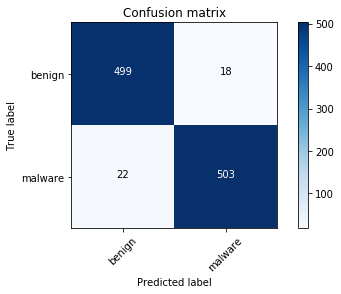

In [134]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(important_features.values,
                                                                                np.arange(0, len(important_features_indices) - 1),
                                                                                len(important_features_indices) - 1,
                                                                                convert_categorical_to_ohv=False)

y_pred = do_decision(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 4-3. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

[0.03723619 0.00297211 0.00236954 0.0017864  0.20442843 0.02345481
 0.01231577 0.02958944 0.01385186 0.00043815 0.04643471 0.05893796
 0.07450591 0.01257906 0.03979794 0.07415363 0.06842147 0.02331351
 0.05887807 0.00676556 0.00907026 0.00226692 0.00241839 0.00765463
 0.03860289 0.00713354 0.0029836  0.03393678 0.10370248]
Confusion matrix, without normalization
[[508   9]
 [  7 518]]
DT accuracy:  0.9846449136276392
f1 score:  0.9847908745247148


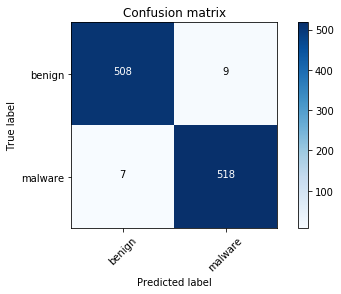

In [135]:
y_pred = do_randomforest(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

68개 feature 중에 29개만 썼지만 성능은 그다지 떨어지지 않습니다.

## 4-4. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 29)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      600         
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
________________________________________________________________________________
activation_8 (Activation)           (None, 1)                       0           
Total params: 821
Trainable params: 821
Non-trainable params: 0
_____________________________________________

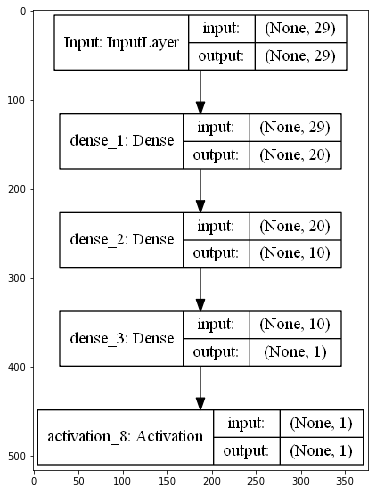

In [136]:
#간단한 모델

inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(1, name = 'dense_3')(dense2)
out = keras.layers.Activation('tanh')(dense3)

second_model = keras.Model(inp, out, name = 'second_dnn')
second_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
second_model.summary(80)
plot_model(second_model, to_file='second_dnn.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (6, 10))
plt.imshow(plt.imread('second_dnn.png'))

In [137]:
second_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 100)

Train on 4168 samples, validate on 1042 samples
Epoch 1/100
4168/4168 [==============================] - 1s 216us/step - loss: 0.8510 - acc: 0.6536 - val_loss: 0.4165 - val_acc: 0.7985
Epoch 2/100
4168/4168 [==============================] - 0s 120us/step - loss: 0.3611 - acc: 0.8541 - val_loss: 0.2785 - val_acc: 0.9357
Epoch 3/100
4168/4168 [==============================] - 0s 120us/step - loss: 0.2884 - acc: 0.9225 - val_loss: 0.2339 - val_acc: 0.9395
Epoch 4/100
4168/4168 [==============================] - 1s 120us/step - loss: 0.2493 - acc: 0.9259 - val_loss: 0.2191 - val_acc: 0.9405
Epoch 5/100
4168/4168 [==============================] - 0s 120us/step - loss: 0.2427 - acc: 0.9259 - val_loss: 0.2109 - val_acc: 0.9424
Epoch 6/100
4168/4168 [==============================] - 1s 120us/step - loss: 0.2209 - acc: 0.9280 - val_loss: 0.2084 - val_acc: 0.9424
Epoch 7/100
4168/4168 [==============================] - 1s 128us/step - loss: 0.2101 - acc: 0.9280 - val_loss: 0.2032 - val_acc: 

4168/4168 [==============================] - 1s 122us/step - loss: 0.0925 - acc: 0.8285 - val_loss: 0.1222 - val_acc: 0.8244
Epoch 61/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.0892 - acc: 0.8383 - val_loss: 0.1211 - val_acc: 0.8522
Epoch 62/100
4168/4168 [==============================] - 1s 125us/step - loss: 0.0894 - acc: 0.8289 - val_loss: 0.1053 - val_acc: 0.8407
Epoch 63/100
4168/4168 [==============================] - 1s 125us/step - loss: 0.0874 - acc: 0.8265 - val_loss: 0.1080 - val_acc: 0.8407
Epoch 64/100
4168/4168 [==============================] - 1s 122us/step - loss: 0.0878 - acc: 0.8256 - val_loss: 0.1226 - val_acc: 0.8484
Epoch 65/100
4168/4168 [==============================] - 1s 126us/step - loss: 0.0832 - acc: 0.8270 - val_loss: 0.1007 - val_acc: 0.7821
Epoch 66/100
4168/4168 [==============================] - 1s 122us/step - loss: 0.0859 - acc: 0.8210 - val_loss: 0.1016 - val_acc: 0.7860
Epoch 67/100
4168/4168 [=======================

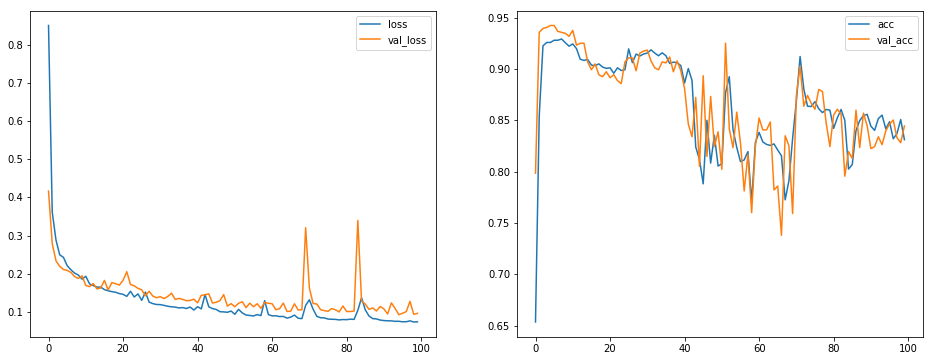

Confusion matrix, without normalization
[[489  28]
 [ 10 515]]
DT accuracy:  0.963531669865643
f1 score:  0.9644194756554307


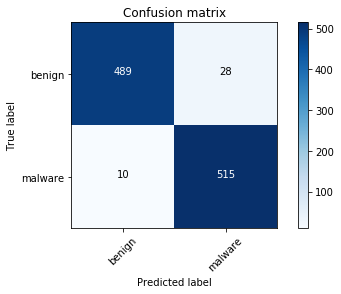

In [138]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(second_model.history.history['loss'])
ax.plot(second_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(second_model.history.history['acc'])
ax.plot(second_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = second_model.predict(x_test) >= 0.5
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

DNN에서는 모델의 크기가 절반정도로 줄었고 학습이 좀 안정됐습니다.

# 5. 그럼 correlation이 낮은 feature들만 사용하면 어떻게 될까?

당연히 모델 성능이 안 좋게 나오겠지요?

위에서 사용하지 않은 feature들만 골라내고, original_data에서 그 자료들만 가져옵니다.

In [139]:
no_important_features_indices = original_data.columns.difference(important_features_indices)
no_important_features_indices = no_important_features_indices.insert(len(no_important_features_indices), item = 'class')
len(no_important_features_indices), no_important_features_indices

(40, Index(['AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'CheckSum',
        'CreationYear', 'E_data', 'FH_char1', 'FH_char11', 'FH_char13',
        'FH_char4', 'FH_char7', 'FH_char8', 'FileAlignment', 'LoaderFlags',
        'MajorImageVersion', 'MajorLinkerVersion', 'MinorImageVersion',
        'MinorLinkerVersion', 'OH_DLLchar1', 'OH_DLLchar10', 'OH_DLLchar3',
        'OH_DLLchar4', 'OH_DLLchar5', 'OH_DLLchar6', 'OH_DLLchar8',
        'OH_DLLchar9', 'SectionAlignment', 'SizeOfCode', 'SizeOfHeaders',
        'SizeOfInitializedData', 'SizeOfStackCommit', 'SizeOfUninitializedData',
        'e_cblp', 'e_cp', 'e_cparhdr', 'e_maxalloc', 'e_sp', 'non_sus_sections',
        'packer', 'class'],
       dtype='object'))

In [140]:
no_important_features = original_data[no_important_features_indices]
no_important_features[:10]

,AddressOfEntryPoint,BaseOfCode,BaseOfData,CheckSum,CreationYear,E_data,FH_char1,FH_char11,FH_char13,FH_char4,...,SizeOfStackCommit,SizeOfUninitializedData,e_cblp,e_cp,e_cparhdr,e_maxalloc,e_sp,non_sus_sections,packer,class
0,1069880,4096,1110016,1194954,1,5.443362,1,0,0,0,...,4096,0,144,3,4,65535,184,3,0,0
1,7680,4096,8192,0,1,2.123522,1,0,0,0,...,4096,0,144,3,4,65535,184,3,0,0
2,28859,4096,32768,67688,1,3.380859,1,0,0,0,...,4096,0,144,3,4,65535,184,4,0,0
3,0,4096,4096,113668,1,0.000000,1,0,0,0,...,4096,0,144,3,4,65535,184,1,0,0
4,13379,4096,16384,69089,1,0.702621,1,0,0,0,...,8192,0,144,3,4,65535,184,4,0,0
5,12916,4096,16384,13458139,1,0.000000,1,0,0,0,...,16384,0,80,2,4,65535,184,4,0,0
6,193832,4096,282624,456052,1,2.843601,1,0,0,0,...,4096,0,144,3,4,65535,184,4,1,0
7,24014,4096,28672,79914,1,1.425743,1,0,0,0,...,4096,0,144,3,4,65535,184,4,0,0
8,43979,4096,49152,118313,1,3.185497,1,0,0,0,...,8192,0,144,3,4,65535,184,4,0,0
9,463191,4096,823296,4119142,1,2.588086,1,0,0,0,...,4096,0,144,3,4,65535,184,5,0,0


그 다음은 마찬가지로 3가지 모델을 전부 돌려봅니다.

## 5-1. Decision Tree를 이용한 모델

shape of x_train and y_train :  (4168, 39) (4168,)
shape of x_test  and y_test  :  (1042, 39) (1042,)
Confusion matrix, without normalization
[[464  36]
 [ 21 521]]
DT accuracy:  0.9452975047984645
f1 score:  0.9481346678798909


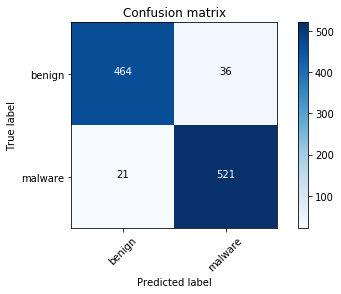

In [142]:
# Diffusion matrix를 그리기 위해서는 y_train, y_test가 multiclass여야합니다. one-hot vector는 multilabel로 취급됩니다.
# 따라서 convert_categorical_to_ohv = False 로 합니다.
x_train, y_train, x_test, y_test, num_features, num_classes = generate_training_and_test_data(no_important_features.values,
                                                                            np.arange(0, len(no_important_features_indices) - 1),
                                                                            len(no_important_features_indices) - 1,
                                                                            convert_categorical_to_ohv=False)

y_pred = do_decision(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

## 3-2. RandomForest를 이용한 모델

이번에는 RandomForest를 이용한 모델입니다.

중간 결과로 출력되는 68개 항목을 가진 벡터(행렬)은, 68개의 feature가 결과에 얼마나 영향을 끼치는지를 계산한 값입니다. 이 값이 클 수록 결과에 미치는 영향이 큽니다. 즉, 더 **중요한** feature입니다. 이것에 대한 분석은 나중에...

[1.36263743e-01 2.04660759e-02 5.73384378e-02 1.54428998e-01
 2.62840532e-03 1.08909825e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.95875898e-06 7.50028822e-04 2.24774274e-03
 0.00000000e+00 4.77329627e-05 8.76082771e-02 8.70361506e-02
 3.97326740e-02 3.68116054e-02 1.31265144e-04 0.00000000e+00
 5.75285024e-06 1.12629863e-02 0.00000000e+00 0.00000000e+00
 4.55194603e-04 9.23661584e-07 0.00000000e+00 6.89370396e-02
 4.66734428e-04 5.92541577e-02 2.36801411e-02 2.55605683e-02
 7.95274170e-03 7.89234586e-03 7.03087010e-04 5.32476928e-04
 1.03704715e-03 4.27427071e-02 1.51121749e-02]
Confusion matrix, without normalization
[[476  24]
 [ 10 532]]
DT accuracy:  0.9673704414587332
f1 score:  0.9690346083788707


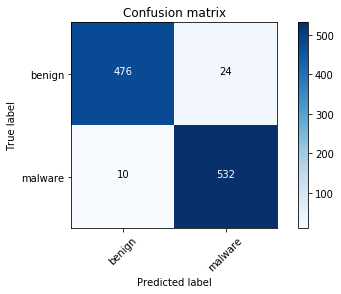

In [143]:
y_pred = do_randomforest(x_train, y_train, x_test)
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

보다시피, 간단한 문제에서는 신경망까지 안 가고 잘 정의된 기계학습 모델을 사용하는 것으로 충분합니다.

## 3-3. DNN을 이용한 모델

신경망을 이용한 모델을 만들어서 성능을 비교해 보겠습니다.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
Input (InputLayer)                  (None, 39)                      0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 20)                      800         
________________________________________________________________________________
dense_2 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_3 (Dense)                     (None, 1)                       11          
________________________________________________________________________________
activation_13 (Activation)          (None, 1)                       0           
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________

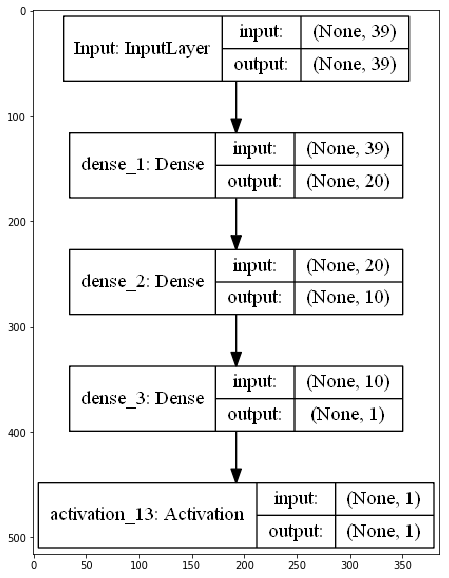

In [150]:
#간단한 모델
inp = keras.layers.Input(shape = (num_features,), name = 'Input')
dense1 = keras.layers.Dense(20, activation = 'relu', name = 'dense_1')(inp)
dense2 = keras.layers.Dense(10, activation = 'relu', name = 'dense_2')(dense1)
dense3 = keras.layers.Dense(1, name = 'dense_3')(dense2)
out = keras.layers.Activation('tanh')(dense3)

third_model = keras.Model(inp, out, name = 'third_dnn')
third_model.compile(optimizer = keras.optimizers.adam(lr=0.001),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
third_model.summary(80)
plot_model(third_model, to_file='third_dnn.png', show_shapes = True, show_layer_names=True)
plt.figure(figsize = (8, 10))
plt.imshow(plt.imread('third_dnn.png'))

In [151]:
third_model.fit(x = x_train, y = y_train,
                validation_data = [x_test, y_test],
                initial_epoch = 0,
                epochs = 100)

Train on 4168 samples, validate on 1042 samples
Epoch 1/100
4168/4168 [==============================] - 1s 242us/step - loss: 0.6741 - acc: 0.5672 - val_loss: 0.6691 - val_acc: 0.5509
Epoch 2/100
4168/4168 [==============================] - 1s 120us/step - loss: 0.6464 - acc: 0.6396 - val_loss: 0.6388 - val_acc: 0.7370
Epoch 3/100
4168/4168 [==============================] - 1s 120us/step - loss: 0.5997 - acc: 0.7102 - val_loss: 0.5862 - val_acc: 0.6641
Epoch 4/100
4168/4168 [==============================] - 1s 121us/step - loss: 0.5413 - acc: 0.7606 - val_loss: 0.5351 - val_acc: 0.7668
Epoch 5/100
4168/4168 [==============================] - 1s 122us/step - loss: 0.5083 - acc: 0.7663 - val_loss: 0.5033 - val_acc: 0.7812
Epoch 6/100
4168/4168 [==============================] - 1s 122us/step - loss: 0.4800 - acc: 0.7898 - val_loss: 0.4865 - val_acc: 0.7850
Epoch 7/100
4168/4168 [==============================] - 1s 122us/step - loss: 0.4543 - acc: 0.7961 - val_loss: 0.4768 - val_acc: 

4168/4168 [==============================] - 0s 120us/step - loss: 0.3696 - acc: 0.8534 - val_loss: 0.4142 - val_acc: 0.8311
Epoch 61/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3667 - acc: 0.8563 - val_loss: 0.3991 - val_acc: 0.8493
Epoch 62/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3600 - acc: 0.8553 - val_loss: 0.4602 - val_acc: 0.7994
Epoch 63/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3922 - acc: 0.8352 - val_loss: 0.3959 - val_acc: 0.8493
Epoch 64/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3540 - acc: 0.8565 - val_loss: 0.3987 - val_acc: 0.8407
Epoch 65/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3530 - acc: 0.8544 - val_loss: 0.3991 - val_acc: 0.8503
Epoch 66/100
4168/4168 [==============================] - 0s 119us/step - loss: 0.3475 - acc: 0.8575 - val_loss: 0.3923 - val_acc: 0.8493
Epoch 67/100
4168/4168 [=======================

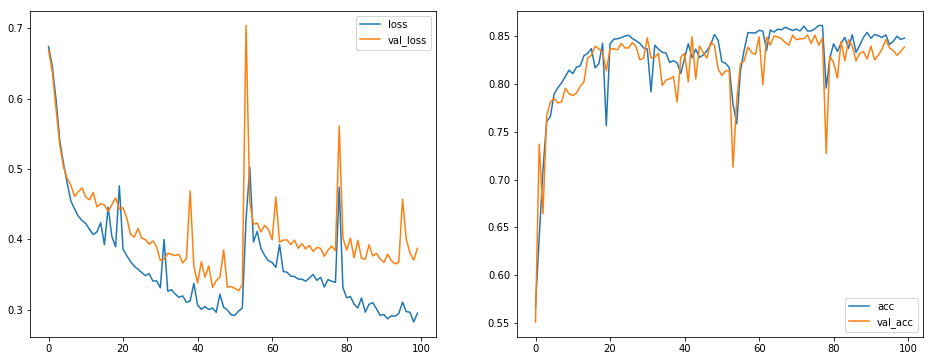

Confusion matrix, without normalization
[[411  89]
 [ 55 487]]
DT accuracy:  0.8618042226487524
f1 score:  0.8711985688729876


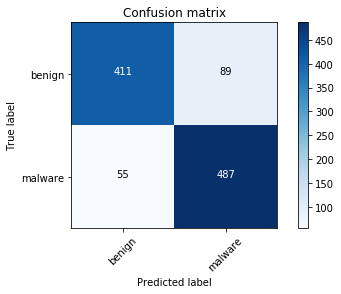

In [152]:
fig = plt.figure(figsize = (16, 6))
ax = plt.subplot(1, 2, 1)
ax.plot(third_model.history.history['loss'])
ax.plot(third_model.history.history['val_loss'])
ax.legend(['loss', 'val_loss'])
ax = plt.subplot(1, 2, 2)
ax.plot(third_model.history.history['acc'])
ax.plot(third_model.history.history['val_acc'])
ax.legend(['acc', 'val_acc'])
plt.show()

y_pred = third_model.predict(x_test) >= 0.5
print('DT accuracy: ', do_confusion(y_test, y_pred))
print("f1 score: ", do_f1(y_test, y_pred))

feature의 중요도가 낮은 경우, 다른 기계학습모델보다 신경망에 미치는 영향이 더 큰 것처럼 보입니다.